<a href="https://colab.research.google.com/github/monuminu/S-P-Data-Science-Challeng/blob/master/S%26P_Data_Science_Challeng.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www.apache.org/dist/spark/spark-2.4.8/spark-2.4.8-bin-hadoop2.7.tgz
!tar xf spark-2.4.8-bin-hadoop2.7.tgz
!pip install -q findspark
!pip install pyspark_dist_explore
!pip install lightgbm
!pip install https://s3-us-west-2.amazonaws.com/xgboost-nightly-builds/xgboost-1.4.0_SNAPSHOT%2B4224c08cacceba3f83f90e387c07aa6205a83bfa-py3-none-manylinux2010_x86_64.whl

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.8-bin-hadoop2.7"

### Loading the Spark Context

In [ ]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [ ]:
from pyspark import SparkContext, SparkConf
from pyspark.conf import SparkConf
from pyspark.sql import HiveContext,SQLContext,SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import *

from pyspark_dist_explore import hist
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import datetime
import seaborn as sns
pd.set_option('float_format', '{:f}'.format)

In [ ]:
!unzip "/content/gdrive/MyDrive/Takeout/sp.zip"

### Loading the all the Data

In [ ]:
userProfile_df = spark.read.option("header" , "true").option("sep" , ",").option("inferSchema","true").format("csv").load(r"file:///content/userProfileDetails.csv")
userProfile_df = userProfile_df.drop("_c0")
userProfile_df.show(5)

+-------+-------------------+--------------------+--------------------+------------------+--------------------+
| UserID|   RegistrationDate|      Industry Focus|   companyTypeRollup|Platform 2 Profile|  Platform 1 Profile|
+-------+-------------------+--------------------+--------------------+------------------+--------------------+
|2002835|2019-01-17 18:01:00|          Financials|      Private Equity|              None|Investment Manage...|
|2002867|2019-01-17 14:49:00|Information Techn...|Professional Serv...|              None|Professional Serv...|
|2002933|2019-01-17 17:05:00|                null|     Commercial Bank|              None|   Commercial Lender|
|2002957|2019-01-17 14:03:00|         Industrials|Professional Serv...|              None|               Other|
|2002997|2019-01-17 12:42:00|          Financials|Professional Serv...|              None|Professional Serv...|
+-------+-------------------+--------------------+--------------------+------------------+--------------

In [ ]:
platform1Usage_df = spark.read.option("header" , "true").option("sep" , ",").option("inferSchema","true").format("csv").load(r"file:///content/Platform1usage.csv")
platform1Usage_df = platform1Usage_df.drop("_c0")
platform1Usage_df = platform1Usage_df.fillna(value=0,subset=[item for item in platform1Usage_df.columns if item not in ["UserID"]])
platform1Usage_df.toPandas().head()

,UserID,14,142,18,21,22,23,24,24101,24122,24700,24701,24702,24703,24704,24705,24706,24707,24708,24709,25,25170,25171,25172,25173,25174,25281,25301,25302,25338,25427,25451,25454,25478,25482,25487,25508,25509,25510,25511,...,25643,25647,25648,25649,25651,25652,25655,25656,25661,25663,25671,25672,25673,25676,25678,25685,25706,25712,25724,25737,25776,25779,25817,25818,25819,27,28,29,31,32,36,37,39,6,8104,8113,8115,8116,8117,9
0,2101760,1.000000,2.000000,0.000000,304.000000,67.000000,0.000000,520.000000,3.000000,275.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,307.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,8.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,418.000000,0.000000,24.000000,218.000000,360.000000,1.000000,0.000000,162.000000,0.000000,1303.530400,0.000000,19.380600,2.779300,0.000000,1.000000
1,1391374,1.000000,0.000000,0.000000,1076.000000,243.000000,1.000000,581.000000,3.000000,407.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,68.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1860.000000,0.000000,28.000000,4.000000,133.000000,33.000000,0.000000,98.000000,364.000000,73864.733200,0.000000,5.255800,2.066300,0.000000,179.000000
2,795305,0.000000,0.000000,0.000000,96.000000,19.000000,2.000000,87.000000,1.000000,74.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,93.000000,24.000000,6.000000,3.000000,6.000000,0.000000,1.000000,15.000000,91.000000,67.880900,0.000000,0.000000,0.000000,0.000000,2.000000
3,2527014,1.000000,0.000000,0.000000,0.000000,9.000000,6.000000,201.000000,0.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,17.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,41.000000,0.000000,2.000000,211.000000,0.000000,0.000000,0.000000,525.000000,0.000000,237.941800,0.000000,0.000000,0.000000,0.000000,0.000000
4,2221022,0.000000,0.000000,0.000000,3.000000,21.000000,0.000000,19.000000,13.000000,11.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,42.000000,0.000000,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,5.000000,0.000000,0.000000,41.000000

In [ ]:
platform2Usage_df = spark.read.option("header" , "true").option("sep" , ",").format("csv").load(r"file:///content/Platform2usage.csv")
platform2Usage_df = platform2Usage_df.drop("_c0")
platform2Usage_df.show(5)

+------+--------------+------------------+
|UserID|AccessMonthKey|              Hits|
+------+--------------+------------------+
| 27339|        201906|1.9999999999999998|
| 27339|        201907|               2.0|
| 27339|        202002|1.9999999999999998|
| 27339|        202007|1.9999999999999998|
|191243|        201907|2.6599999999999993|
+------+--------------+------------------+
only showing top 5 rows



In [ ]:
prediction_df = spark.read.option("header" , "true").option("sep" , ",").format("csv").load(r"file:///content/predictionSet.csv")
prediction_df = prediction_df.drop("_c0")
prediction_df = prediction_df.na.fill(value=0,subset=[item for item in prediction_df.columns if item not in ["UserID","RegistrationDate","Industry Focus","companyTypeRollup","Platform 1 Profile"]])
prediction_df.toPandas().head()

,UserID,14,142,18,21,22,23,24,24101,24122,24700,24701,24702,24703,24704,24705,24706,24707,24708,24709,25,25170,25171,25172,25173,25174,25281,25301,25302,25338,25427,25451,25454,25478,25482,25487,25508,25509,25510,25511,...,25651,25652,25655,25656,25661,25663,25671,25672,25673,25676,25678,25685,25706,25712,25724,25737,25776,25779,25817,25818,25819,27,28,29,31,32,36,37,39,6,8104,8113,8115,8116,8117,9,RegistrationDate,Industry Focus,companyTypeRollup,Platform 1 Profile
0,1172115,8.0,1027.0,null,390.0,335.0,3.0,3775.0,34.0,593.0,null,null,null,1.0,null,null,null,null,null,null,779.0,null,66.0,null,null,null,null,null,null,null,null,null,null,1.0,null,null,null,null,null,null,...,null,null,null,null,1.0,null,1.0,2.0,null,null,null,null,3.0,null,3.0,null,8.0,null,null,29.0,null,4803.0,3.0,577.0,488.0,1227.0,6.0,1.0,3435.0,19.0,3054.8652000000006,null,342.7131000000003,375.5981999999999,1.1973999999999998,2694.0,2014-12-02T08:14:00.000Z,Utilities,Commercial Bank,Investment Banking
1,2367235,3.0,null,null,111.0,9.0,null,115.0,9.0,104.0,null,null,null,null,null,null,null,null,null,null,9.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,...,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,18.0,null,8.0,23.0,1538.0,null,null,85.0,null,5.679899999999999,null,null,2.8622,null,null,2020-06-05T17:25:00.000Z,null,Non-FI Corporates,Non-financial Corporation
2,1615483,null,null,null,10.0,9.0,null,14.0,6.0,10.0,null,null,null,null,null,null,null,null,null,null,12.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,...,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,1.0,null,60.0,null,null,null,null,null,null,1.1872999999999996,null,null,0.06439999999999997,null,922.0,2017-04-21T06:54:00.000Z,null,Investment Banking,Investment Management
3,2313389,1.0,null,null,7.0,13.0,null,189.0,8.0,177.0,null,null,null,null,null,null,null,null,null,null,657.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,...,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,1801.0,null,14.0,1.0,39.0,null,null,39.0,13.0,28.588500000000014,null,null,0.514,null,16.0,2020-03-19T16:31:00.000Z,Financials,Academia,None
4,2657807,null,null,null,1.0,2.0,null,103.0,6.0,3.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,...,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,18.0,null,6.0,null,45.0,null,null,null,null,1182.0094999999997,null,null,93.4919,null,42.0,2021-03-02T17:10:00.000Z,Utilities,Commercial Bank,Investment Banking


### Rolling up Platform2 Usage per UserID

In [ ]:
platform2UsageRollUp_df = platform2Usage_df.groupby("UserID").agg(F.sum("Hits").alias("TotHits"))
use2RolupP = platform2UsageRollUp_df.toPandas()
quantile_value = use2RolupP.quantile(0.9, numeric_only=True)["TotHits"]
from pyspark.sql.functions import udf
@udf(returnType=FloatType()) 
def outerlier_clipping(value):
    if value < quantile_value :
        return value
    else:
        return float(quantile_value)

outerlier_clipping_udf = udf(outerlier_clipping)
platform2UsageRollUp_df = platform2UsageRollUp_df.withColumn("TotHits", outerlier_clipping(F.col("TotHits")))
use2RolupP = platform2UsageRollUp_df.toPandas()

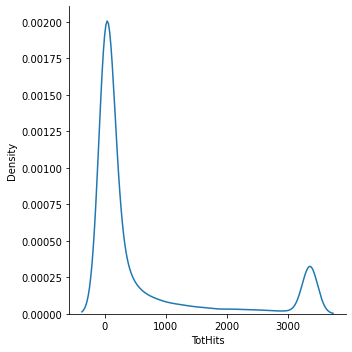

In [ ]:
sns.displot(
    use2RolupP, x="TotHits",kind="kde",
    height=5, facet_kws=dict(margin_titles=True),
)

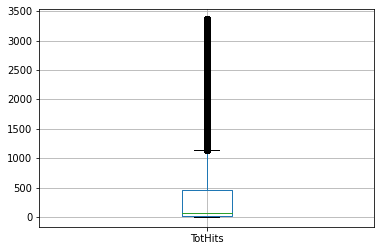

In [ ]:
use2RolupP.boxplot(column=['TotHits'])

### Joining UserProfile , Platform1 and Platform2 Usage to Training Dataset

In [ ]:
platform1UsageUser_df = platform1Usage_df.join(userProfile_df,"UserID","inner")
plt1_plt2_df = platform1UsageUser_df.join(platform2UsageRollUp_df,"UserID","left")
plt1_plt2_df = plt1_plt2_df.select(prediction_df.columns+ ["TotHits"])

### Feature Engineer

In [ ]:
today = datetime.date(2021,8,13)
plt1_plt2_df = plt1_plt2_df.withColumn('NumberOfDaysOldCustomer',F.datediff(F.lit(today), F.col("RegistrationDate")))
prediction_df = prediction_df.withColumn('NumberOfDaysOldCustomer',F.datediff(F.lit(today), F.col("RegistrationDate")))
plt1_plt2_df = plt1_plt2_df.drop("RegistrationDate")
prediction_df = prediction_df.drop("RegistrationDate")

In [ ]:
df = plt1_plt2_df.toPandas()
df.to_csv("/content/gdrive/MyDrive/Takeout/data1.csv", index = False)

In [ ]:
plt1_plt2_df = plt1_plt2_df.withColumn("isUsingPlatform2", F.when(F.col("TotHits") > F.lit(1000), F.lit(1)).otherwise(F.lit(0)))
plt1_plt2_df = plt1_plt2_df.drop("TotHits")

In [ ]:
df = plt1_plt2_df.toPandas()
df.to_csv("/content/gdrive/MyDrive/Takeout/data.csv", index = False)

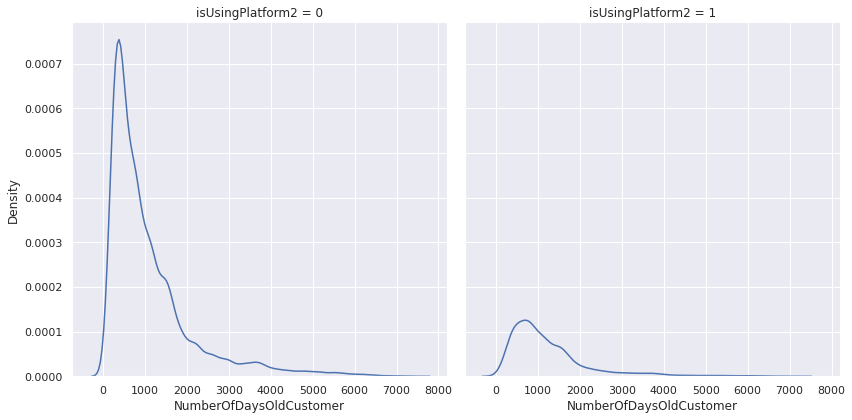

In [ ]:
sns.set_theme(style="darkgrid")
sns.displot(
    df, x="NumberOfDaysOldCustomer", col="isUsingPlatform2",kind="kde",
    height=6, facet_kws=dict(margin_titles=True),
)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import KFold, cross_val_score, train_test_split # Model evaluation
from sklearn.base import BaseEstimator,TransformerMixin, ClassifierMixin
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler # Preprocessing
from xgboost import XGBClassifier, plot_importance # XGBoost
from sklearn.pipeline import Pipeline # Streaming pipelines
from sklearn.decomposition import KernelPCA, PCA # Dimensionality reduction
from sklearn.feature_selection import SelectFromModel # Dimensionality reduction
from sklearn.model_selection import learning_curve, validation_curve, GridSearchCV # Model evaluation
from sklearn.base import clone # Clone estimator
import scipy.stats as st
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
import xgboost as xgb
from sklearn.metrics import silhouette_score,roc_auc_score
from sklearn.cluster import KMeans
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
import warnings
warnings.filterwarnings("ignore")

In [ ]:
def drop_cols_with_unique_values(df):
    #check for columns having only a single unique values 
    col_with_single_unique_value = []
    for col in df.columns:
        if len(df[col].unique()) == 1 :
            col_with_single_unique_value.append(col)

    df.drop(col_with_single_unique_value,axis = 1 , inplace= True)
    return df

def scaling(data,colname):
    scaler = MinMaxScaler()
    return scaler.fit_transform(data[[colname]])
    
def one_hot(data,colname):
    data[colname] = data[colname].astype("object")
    one_hot_encoded_data = pd.get_dummies(data[[colname]],prefix = colname,drop_first= True)
    data.drop([colname],axis = 1,inplace = True)
    data = pd.concat([data,one_hot_encoded_data],axis = 1)
    return data

In [ ]:
df = pd.read_csv("/content/gdrive/MyDrive/Takeout/data1.csv")
df.head()

,UserID,14,142,18,21,22,23,24,24101,24122,24700,24701,24702,24703,24704,24705,24706,24707,24708,24709,25,25170,25171,25172,25173,25174,25281,25301,25302,25338,25427,25451,25454,25478,25482,25487,25508,25509,25510,25511,...,25652,25655,25656,25661,25663,25671,25672,25673,25676,25678,25685,25706,25712,25724,25737,25776,25779,25817,25818,25819,27,28,29,31,32,36,37,39,6,8104,8113,8115,8116,8117,9,Industry Focus,companyTypeRollup,Platform 1 Profile,TotHits,NumberOfDaysOldCustomer
0,2101760,1.000000,2.000000,0.000000,304.000000,67.000000,0.000000,520.000000,3.000000,275.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,307.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,418.000000,0.000000,24.000000,218.000000,360.000000,1.000000,0.000000,162.000000,0.000000,1303.530400,0.000000,19.380600,2.779300,0.000000,1.000000,Consumer Staples,Private Equity,Investment Management,319.491240,784.000000
1,1391374,1.000000,0.000000,0.000000,1076.000000,243.000000,1.000000,581.000000,3.000000,407.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,68.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1860.000000,0.000000,28.000000,4.000000,133.000000,33.000000,0.000000,98.000000,364.000000,73864.733200,0.000000,5.255800,2.066300,0.000000,179.000000,Consumer Staples,Investment Management,Investment Management,253.626000,1650.000000
2,795305,0.000000,0.000000,0.000000,96.000000,19.000000,2.000000,87.000000,1.000000,74.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,93.000000,24.000000,6.000000,3.000000,6.000000,0.000000,1.000000,15.000000,91.000000,67.880900,0.000000,0.000000,0.000000,0.000000,2.000000,Consumer Discretionary,Investment Management,Investment Management,295.699520,6112.000000
3,2527014,1.000000,0.000000,0.000000,0.000000,9.000000,6.000000,201.000000,0.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,17.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,41.000000,0.000000,2.000000,211.000000,0.000000,0.000000,0.000000,525.000000,0.000000,237.941800,0.000000,0.000000,0.000000,0.000000,0.000000,Financials,Professional Services,Professional Services,57.352710,290.000000
4,2221022,0.000000,0.000000,0.000000,3.000000,21.000000,0.000000,19.000000,13.000000,11.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,42.000000,0.000000,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000

# **1. What general patterns do you observe in the data?**

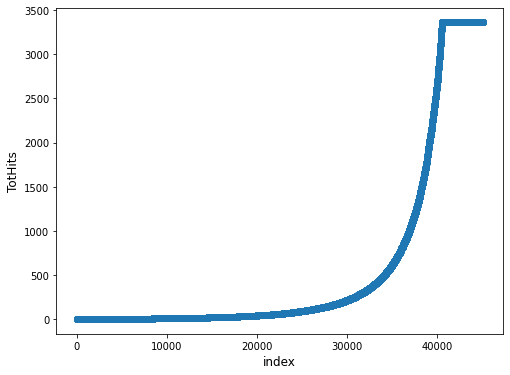

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(range(df.shape[0]), np.sort(df.TotHits.values))
plt.xlabel('index', fontsize=12)
plt.ylabel('TotHits', fontsize=12)
plt.show()

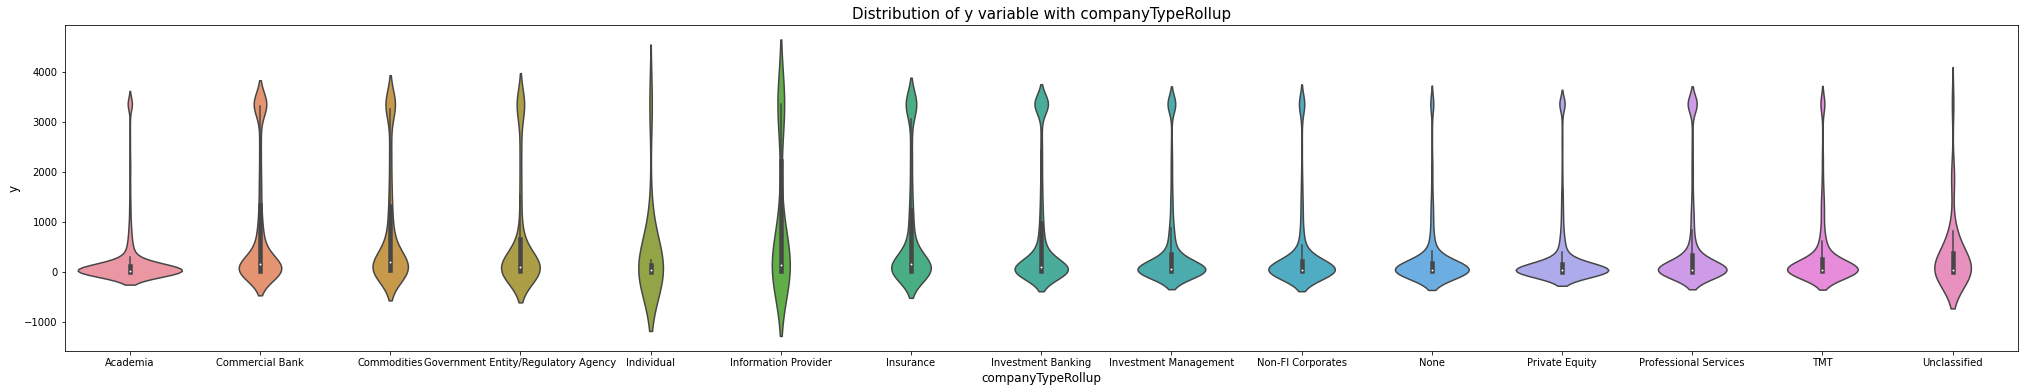

In [ ]:
var="companyTypeRollup"
colu_order=np.sort(df[var].unique()).tolist()
plt.figure(figsize=(35,6))
sns.violinplot(x=var,y="TotHits",data=df,order=colu_order)
plt.xlabel(var,fontsize=12)
plt.ylabel("y",fontsize=12)
plt.title("Distribution of y variable with "+var, fontsize=15)
plt.show()

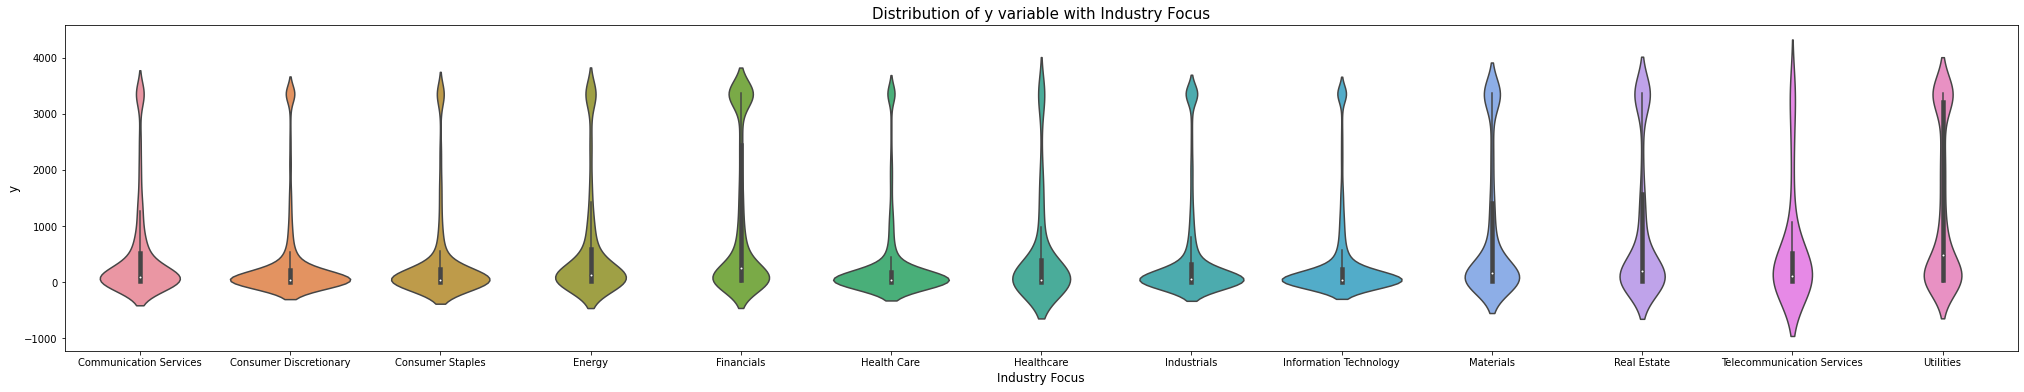

In [ ]:
var="Industry Focus"
colu_order=np.sort(df[var].dropna().unique()).tolist()
plt.figure(figsize=(35,6))
sns.violinplot(x=var,y="TotHits",data=df,order=colu_order)
plt.xlabel(var,fontsize=12)
plt.ylabel("y",fontsize=12)
plt.title("Distribution of y variable with "+var, fontsize=15)
plt.show()

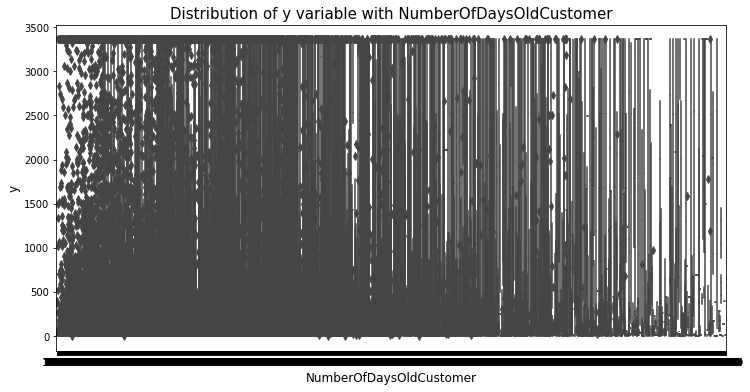

In [ ]:
var="NumberOfDaysOldCustomer"
colu_order=np.sort(df[var].unique()).tolist()
plt.figure(figsize=(12,6))
sns.boxplot(x=var,y="TotHits",data=df,order=colu_order)
plt.xlabel(var,fontsize=12)
plt.ylabel("y",fontsize=12)
plt.title("Distribution of y variable with "+var, fontsize=15)
plt.show()

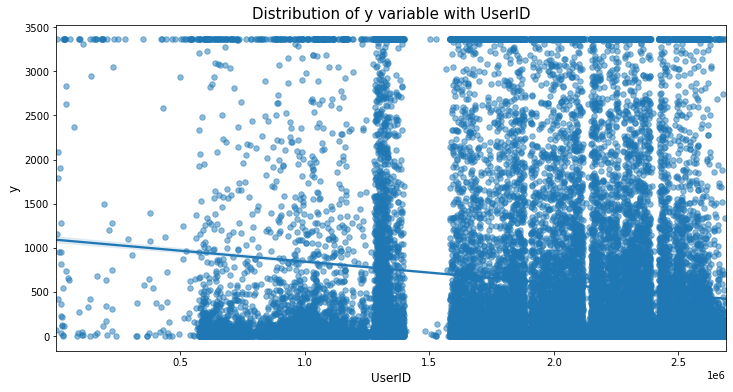

In [ ]:
var = "UserID"
plt.figure(figsize=(12,6))
sns.regplot(x=var, y='TotHits', data=df, scatter_kws={'alpha':0.5, 's':30})
plt.xlabel(var, fontsize=12)
plt.ylabel('y', fontsize=12)
plt.title("Distribution of y variable with "+var, fontsize=15)
plt.show()

In [ ]:
data = df.drop(["UserID"],axis = 1)
data["25591"] = data["25591"].astype(float)
one_hot_check = True
if one_hot_check:
    data = one_hot(data , 'Industry Focus')   
    data = one_hot(data , 'companyTypeRollup')   
    data = one_hot(data , 'Platform 1 Profile')     

# **5. What was the target variable you used in your analysis, and what was the logic behind the same?**

In [ ]:
CUTOFF = 1500
data["isUsingPlatform2"] = data["TotHits"].apply(lambda x : 0 if x < CUTOFF else 1)
data = data.drop("TotHits",axis=1)
X = data.drop("isUsingPlatform2",axis=1)
y = data["isUsingPlatform2"].values


scale = MinMaxScaler()
cols = X.iloc[:,:143].columns.tolist()
X.iloc[:,:144] = X.iloc[:,:144].fillna(0)
X.iloc[:,:143] = pd.DataFrame(scale.fit_transform(X.iloc[:,:143].values), columns=cols, index=X.index)  

### **2. Do you observe any logical groupings of users? If so, how did you identify them?**

running with K 2
running with K 3
running with K 4
running with K 5
running with K 6
running with K 7
running with K 8
running with K 9
running with K 10


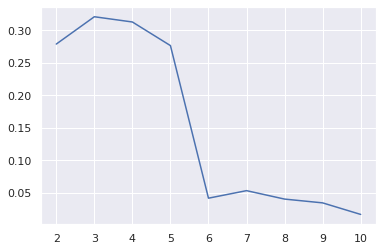

In [ ]:
sil = []
kmax = 10

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(2, kmax+1):
    print("running with K", k)
    kmeans = KMeans(n_clusters = k).fit(X.iloc[:,:143])
    labels = kmeans.labels_
    sil.append(silhouette_score(X, labels, metric = 'euclidean'))

sns.lineplot([2,3,4,5,6,7,8,9,10], sil)

In [ ]:
from sklearn.cluster import KMeans
clustering = KMeans(n_clusters=5, random_state=0).fit(X.iloc[:,:143])
X["Platform1_bahviour_cluster"] = clustering.labels_
X["Platform1_bahviour_cluster"].value_counts()

1    42675
4     1523
2      373
0      218
3      211
Name: Platform1_bahviour_cluster, dtype: int64

### **Performing PCA over the Numerical Features**

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.9, svd_solver='full')
D= pca.fit_transform(X.iloc[:,:143])
X = pd.concat([pd.DataFrame(D),X.iloc[:,143:]], axis = 1)
print(pca.explained_variance_ratio_)

[0.07815137 0.06670712 0.05326455 0.03638612 0.03197652 0.02857793
 0.02797242 0.02751376 0.02604107 0.02221897 0.02028149 0.01853007
 0.01820263 0.01668502 0.01630728 0.01617365 0.01522938 0.01464433
 0.01363418 0.01276786 0.01255694 0.01235615 0.0121612  0.01180468
 0.01137711 0.01123395 0.01110949 0.01057826 0.01037139 0.00990887
 0.00930438 0.00896997 0.00865425 0.00861602 0.00829245 0.00813789
 0.00800657 0.00786375 0.00775905 0.00766735 0.00755808 0.00692917
 0.00688438 0.00681961 0.00642354 0.00599227 0.00585115 0.00582679
 0.00576903 0.00567515 0.00563182 0.00550078 0.00539349 0.00537868
 0.00521227 0.00515814 0.00510567 0.00488679 0.00457939 0.0045081
 0.00430513 0.00428757 0.00413142 0.00408187 0.0040336  0.00402678
 0.00391811]


### Binning Numerical Variable Number of Days

In [ ]:
# discretization transform the raw data
from sklearn.preprocessing import KBinsDiscretizer
kbins = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile')
X.iloc[:,143:144] = kbins.fit_transform(X.iloc[:,143:144])

### **Model Training With Stacking of XGBoost , GBM and LGBM with K Fold Cross Validation**

# **Cross Validation using Stratified K Fold**

In [ ]:
errxgb=[]
y_pred_tot_xgb=[]
from sklearn.model_selection import StratifiedKFold
fold=StratifiedKFold(n_splits=5,shuffle=True,random_state=32)
i=1
# declare parameters
params = {
            'objective':'binary:logistic',
            'eta':0.05,
            'max_depth': 8,
            'alpha': 10,
            'learning_rate': 0.1,
            'n_estimators':4000,
            'gpu_id' :0,
            'tree_method' : 'gpu_hist',
            'eval_metric' : 'auc',
            'n_jobs' : -1,
            'subsample': 0.7,
            'colsample_bytree': 0.7
        }         
      
for train_index, test_index in fold.split(X,y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    m=XGBClassifier(**params)
    m.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test, y_test)], early_stopping_rounds=100,verbose=0)
    preds=m.predict_proba(X_test)[:,-1]
    print("ROC_AUC Score: ", roc_auc_score(y_test, preds))
    errxgb.append(roc_auc_score(y_test,preds))

ROC_AUC Score:  0.7913385651198035
ROC_AUC Score:  0.8080608859265281
ROC_AUC Score:  0.8054325858846438
ROC_AUC Score:  0.8057494095405002
ROC_AUC Score:  0.814320119203205


In [ ]:
class StackingEstimator(BaseEstimator, TransformerMixin):
    def __init__(self, estimator):
        self.estimator = estimator
    def fit(self, X, y=None, **fit_params):
        self.estimator.fit(X, y, **fit_params)
        return self
    def transform(self, X):
        #X = check_array(X)
        X_transformed = np.copy(X)
        # add class probabilities as a synthetic feature
        if issubclass(self.estimator.__class__, ClassifierMixin) and hasattr(self.estimator, 'predict_proba'):
            X_transformed = np.hstack((self.estimator.predict_proba(X), X))
        # add class prodiction as a synthetic feature
        X_transformed = np.hstack((np.reshape(self.estimator.predict(X), (-1, 1)), X_transformed))
        return X_transformed

stacked_pipeline = make_pipeline(
    StackingEstimator(estimator=LGBMClassifier( n_estimators = 3000, learning_rate = 0.1,device='cpu', n_jobs=-1,max_depth=6)),
    StackingEstimator(estimator=XGBClassifier(n_estimators = 3000,max_depth = 6, learning_rate = 0.1, gpu_id = 0, tree_method = 'gpu_hist', n_jobs=-1,)),
    GradientBoostingClassifier(learning_rate=0.1, n_estimators=3000, subsample=1.0)
)

# Spliting X and y into train and test version
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=3)
stacked_pipeline.fit(X_train, y_train)
preds=stacked_pipeline.predict_proba(X_test)[:,-1]
print("ROC_AUC Score: ", roc_auc_score(y_test, preds))

ROC_AUC Score:  0.9075816095866278


# **6. Provide the top drivers of probability scores per user.**

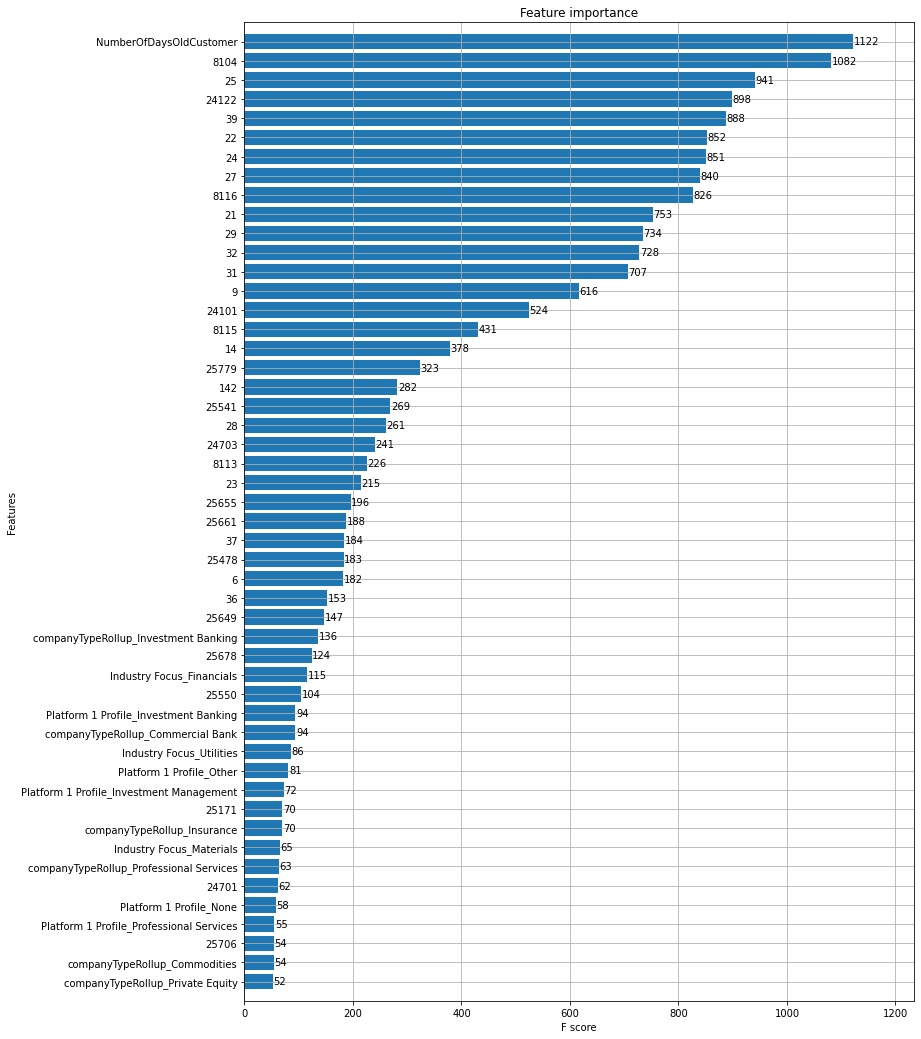

In [ ]:
# plot the important features #
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(m, max_num_features=10, height=0.8, ax=ax)
plt.show()

# **4. For the users who don’t use Platform 2 (predictionSet.csv), you are expected to provide a probability score for their likelihood to switch from Platform 1 to Platform 2. You must provide probability scores for each user.**

In [ ]:
pred_df = prediction_df.toPandas()
pred_df = one_hot(pred_df , 'Industry Focus')   
pred_df = one_hot(pred_df , 'companyTypeRollup')   
pred_df = one_hot(pred_df , 'Platform 1 Profile')  
UserID = pred_df["UserID"]
pred_df = pred_df.drop(["UserID","Industry Focus_null"], axis = 1)
cols = pred_df.iloc[:,:143].columns.tolist()
pred_df.iloc[:,:144] = pred_df.iloc[:,:144].fillna(0)
pred_df.iloc[:,:143] = pred_df.iloc[:,:143].replace("null", 0)
pred_df.iloc[:,:143] = pd.DataFrame(scale.fit_transform(pred_df.iloc[:,:143].values), columns=cols, index=pred_df.index)  
pred_df["9"] = pred_df["9"].replace("null",0).astype(float)
pred_df = pred_df.fillna(0)
preds=m.predict_proba(pred_df)[:,-1]
df_pred = pd.DataFrame({"UserID" : UserID, "Prediction" : preds})

In [ ]:
df_pred.head(10)

,UserID,Prediction
0,1172115,0.481893
1,2367235,0.173397
2,1615483,0.254047
3,2313389,0.172153
4,2657807,0.296716
5,2424063,0.074246
6,2346131,0.146496
7,1879115,0.185662
8,1742440,0.504997
9,2687631,0.077055
